In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time



In [2]:
dfi = pd.read_csv('./Data/Electricity/steel_energy.csv')
dfi

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.00,0.0,73.21,100.00,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.00,0.0,66.77,100.00,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.00,0.0,70.28,100.00,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.00,0.0,68.09,100.00,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.00,0.0,64.72,100.00,4500,Weekday,Monday,Light_Load
...,...,...,...,...,...,...,...,...,...,...,...
35035,31/12/2018 23:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,Weekday,Monday,Light_Load
35036,31/12/2018 23:15,3.74,3.74,0.00,0.0,70.71,100.00,83700,Weekday,Monday,Light_Load
35037,31/12/2018 23:30,3.78,3.17,0.07,0.0,76.62,99.98,84600,Weekday,Monday,Light_Load
35038,31/12/2018 23:45,3.78,3.06,0.11,0.0,77.72,99.96,85500,Weekday,Monday,Light_Load


In [3]:
dfi['date'] = pd.to_datetime(dfi['date'], format='%d/%m/%Y %H:%M')
dfi

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,2018-01-01 00:15:00,3.17,2.95,0.00,0.0,73.21,100.00,900,Weekday,Monday,Light_Load
1,2018-01-01 00:30:00,4.00,4.46,0.00,0.0,66.77,100.00,1800,Weekday,Monday,Light_Load
2,2018-01-01 00:45:00,3.24,3.28,0.00,0.0,70.28,100.00,2700,Weekday,Monday,Light_Load
3,2018-01-01 01:00:00,3.31,3.56,0.00,0.0,68.09,100.00,3600,Weekday,Monday,Light_Load
4,2018-01-01 01:15:00,3.82,4.50,0.00,0.0,64.72,100.00,4500,Weekday,Monday,Light_Load
...,...,...,...,...,...,...,...,...,...,...,...
35035,2018-12-31 23:00:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,Weekday,Monday,Light_Load
35036,2018-12-31 23:15:00,3.74,3.74,0.00,0.0,70.71,100.00,83700,Weekday,Monday,Light_Load
35037,2018-12-31 23:30:00,3.78,3.17,0.07,0.0,76.62,99.98,84600,Weekday,Monday,Light_Load
35038,2018-12-31 23:45:00,3.78,3.06,0.11,0.0,77.72,99.96,85500,Weekday,Monday,Light_Load


In [4]:
dfi.drop(['WeekStatus','Day_of_week','Load_Type'],axis=1,inplace=True)

<Axes: >

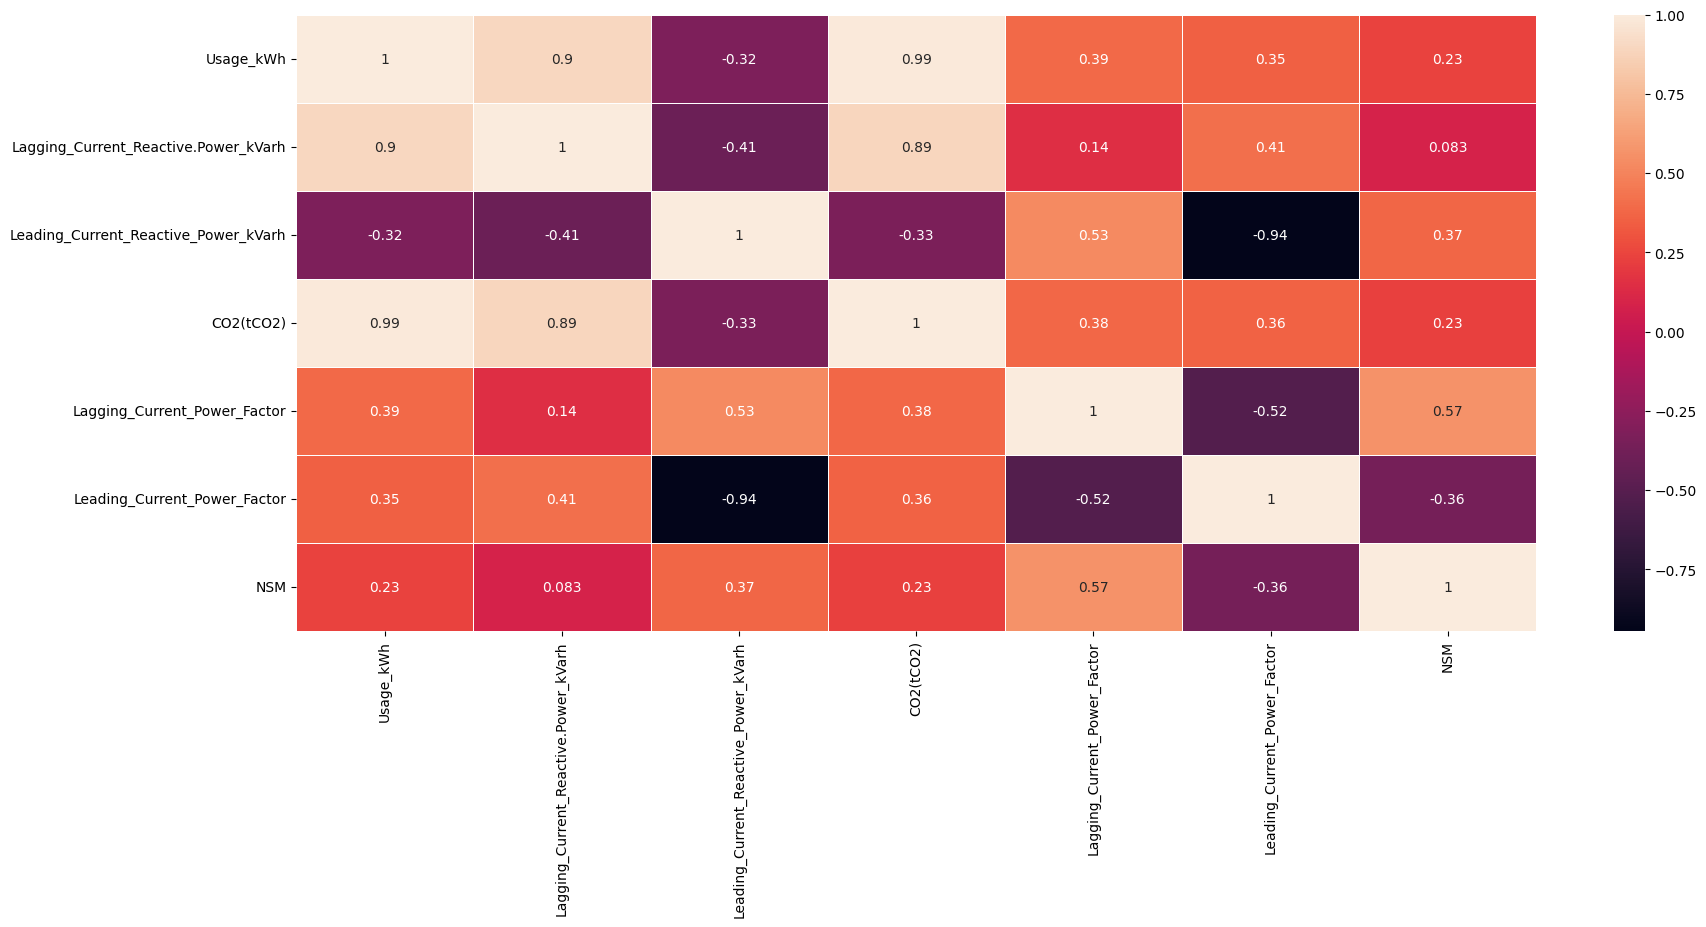

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,8))
corr = dfi.select_dtypes('number').corr()
sns.heatmap(data=corr, annot=True, linewidths=.5,ax=ax)

In [6]:
dfi = dfi.groupby([pd.Grouper(freq='H', key='date')]).mean().reset_index()
dfi

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
0,2018-01-01 00:00:00,3.4575,3.5375,0.0000,0.0,70.1400,100.000,1350.0
1,2018-01-01 01:00:00,3.5025,3.9400,0.0000,0.0,66.5475,100.000,4950.0
2,2018-01-01 02:00:00,3.5300,4.1675,0.0000,0.0,64.7400,100.000,8550.0
3,2018-01-01 03:00:00,3.4550,4.0500,0.0000,0.0,65.0675,100.000,12150.0
4,2018-01-01 04:00:00,3.6175,4.4100,0.0000,0.0,63.5175,100.000,15750.0
...,...,...,...,...,...,...,...,...
8755,2018-12-31 19:00:00,3.9500,0.0000,18.0175,0.0,100.0000,21.675,69750.0
8756,2018-12-31 20:00:00,3.7800,0.0000,16.7325,0.0,100.0000,22.445,73350.0
8757,2018-12-31 21:00:00,3.4375,0.0000,13.3675,0.0,100.0000,24.905,76950.0
8758,2018-12-31 22:00:00,3.5375,3.0875,3.3225,0.0,74.3450,81.270,80550.0


In [7]:
df = dfi.loc[dfi['date'] > '2018-07-01']
df.reset_index(inplace=True)
df = df[['Lagging_Current_Reactive.Power_kVarh','CO2(tCO2)','Lagging_Current_Power_Factor','Leading_Current_Power_Factor','Usage_kWh']]
#df.drop(['date','Leading_Current_Reactive_Power_kVarh','NSM'],axis=1,inplace=True)
df

,Lagging_Current_Reactive.Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,Usage_kWh
0,4.0250,0.0,57.8175,100.000,2.8525
1,4.0850,0.0,57.4850,100.000,2.8700
2,4.0850,0.0,62.6675,100.000,3.3100
3,3.7875,0.0,59.5875,100.000,2.8100
4,3.7875,0.0,59.3075,100.000,2.7900
...,...,...,...,...,...
4410,0.0000,0.0,100.0000,21.675,3.9500
4411,0.0000,0.0,100.0000,22.445,3.7800
4412,0.0000,0.0,100.0000,24.905,3.4375
4413,3.0875,0.0,74.3450,81.270,3.5375


In [8]:
df.ffill()

,Lagging_Current_Reactive.Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,Usage_kWh
0,4.0250,0.0,57.8175,100.000,2.8525
1,4.0850,0.0,57.4850,100.000,2.8700
2,4.0850,0.0,62.6675,100.000,3.3100
3,3.7875,0.0,59.5875,100.000,2.8100
4,3.7875,0.0,59.3075,100.000,2.7900
...,...,...,...,...,...
4410,0.0000,0.0,100.0000,21.675,3.9500
4411,0.0000,0.0,100.0000,22.445,3.7800
4412,0.0000,0.0,100.0000,24.905,3.4375
4413,3.0875,0.0,74.3450,81.270,3.5375


In [9]:
# Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Lagging_Current_Reactive.Power_kVarh,4415.0,12.927970,14.500337,0.0000,2.88000,5.4800,23.05375,66.2400
CO2(tCO2),4415.0,0.010361,0.014130,0.0000,0.00000,0.0000,0.02250,0.0650
Lagging_Current_Power_Factor,4415.0,78.858537,19.804580,37.2975,56.88750,87.0500,95.76500,100.0000
Leading_Current_Power_Factor,4415.0,83.748893,28.360197,13.0850,80.78125,100.0000,100.00000,100.0000
Usage_kWh,4415.0,24.825906,29.352665,2.4650,3.06000,4.0575,48.73500,136.6475


In [10]:
df['nxt_target'] = df['Usage_kWh'].shift(-1)
df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]
df

,Lagging_Current_Reactive.Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,Usage_kWh,nxt_target
0,4.0250,0.0,57.8175,100.000,2.8525,2.8700
1,4.0850,0.0,57.4850,100.000,2.8700,3.3100
2,4.0850,0.0,62.6675,100.000,3.3100,2.8100
3,3.7875,0.0,59.5875,100.000,2.8100,2.7900
4,3.7875,0.0,59.3075,100.000,2.7900,2.7825
...,...,...,...,...,...,...
4410,0.0000,0.0,100.0000,21.675,3.9500,3.7800
4411,0.0000,0.0,100.0000,22.445,3.7800,3.4375
4412,0.0000,0.0,100.0000,24.905,3.4375,3.5375
4413,3.0875,0.0,74.3450,81.270,3.5375,3.7875


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4415 entries, 0 to 4414
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Lagging_Current_Reactive.Power_kVarh  4415 non-null   float64
 1   CO2(tCO2)                             4415 non-null   float64
 2   Lagging_Current_Power_Factor          4415 non-null   float64
 3   Leading_Current_Power_Factor          4415 non-null   float64
 4   Usage_kWh                             4415 non-null   float64
 5   nxt_target                            4415 non-null   float64
dtypes: float64(6)
memory usage: 207.1 KB


In [12]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,Lagging_Current_Reactive.Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,Usage_kWh,nxt_target
0,4.0250,0.0,57.8175,100.0000,2.8525,2.8700
1,4.0850,0.0,57.4850,100.0000,2.8700,3.3100
2,4.0850,0.0,62.6675,100.0000,3.3100,2.8100
3,3.7875,0.0,59.5875,100.0000,2.8100,2.7900
4,3.7875,0.0,59.3075,100.0000,2.7900,2.7825
...,...,...,...,...,...,...
3527,2.6000,0.0,76.6975,99.9950,3.1050,3.0775
3528,2.5725,0.0,76.8200,99.9925,3.0775,3.0850
3529,2.6200,0.0,76.2075,99.9925,3.0850,2.8900
3530,2.6750,0.0,73.3925,100.0000,2.8900,2.8800


In [13]:
train.iloc[:,-1:]

,nxt_target
0,2.8700
1,3.3100
2,2.8100
3,2.7900
4,2.7825
...,...
3527,3.0775
3528,3.0850
3529,2.8900
3530,2.8800


In [14]:
train.iloc[:,:5]


,Lagging_Current_Reactive.Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,Usage_kWh
0,4.0250,0.0,57.8175,100.0000,2.8525
1,4.0850,0.0,57.4850,100.0000,2.8700
2,4.0850,0.0,62.6675,100.0000,3.3100
3,3.7875,0.0,59.5875,100.0000,2.8100
4,3.7875,0.0,59.3075,100.0000,2.7900
...,...,...,...,...,...
3527,2.6000,0.0,76.6975,99.9950,3.1050
3528,2.5725,0.0,76.8200,99.9925,3.0775
3529,2.6200,0.0,76.2075,99.9925,3.0850
3530,2.6750,0.0,73.3925,100.0000,2.8900


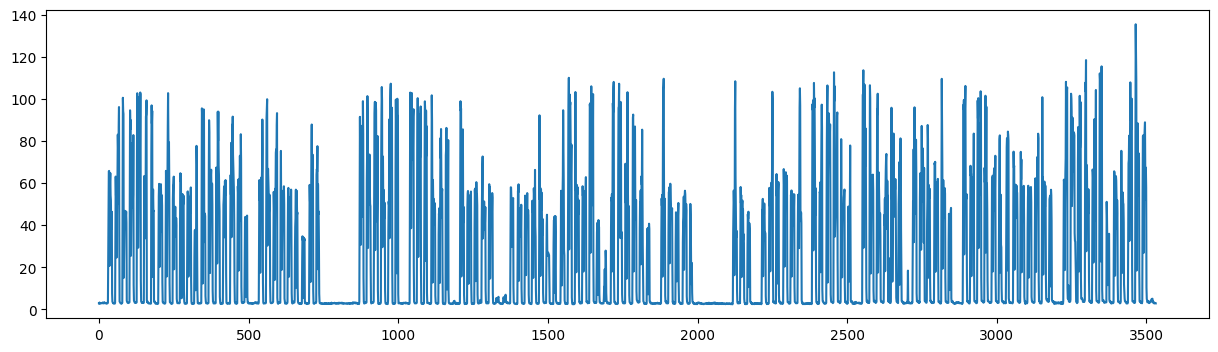

In [15]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["Usage_kWh"])
plt.show()

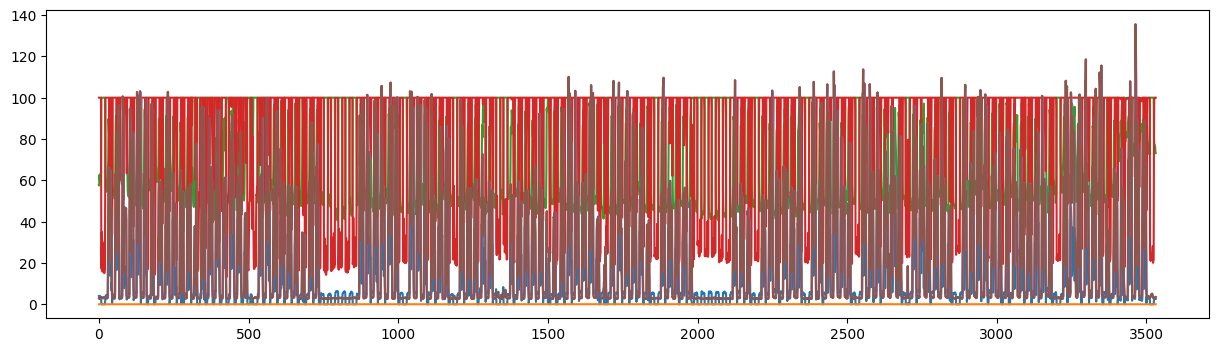

In [16]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [17]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:])
    data = scaler2.fit_transform(data.iloc[:,:5])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [18]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 5
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 5
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [19]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [20]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [21]:
print(X_train.shape)
X_train[0][0]

torch.Size([3522, 10, 5])


tensor([-0.6615, -0.7520, -0.8921,  0.5581, -0.7610])

In [22]:
class QGRU(nn.Module):
    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QGRU, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        self.wires_candidate = [f"wire_candidate_{i}" for i in range(self.n_qubits)]
        self.wires_reset = [f"wire_reset_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        

        self.dev_candidate = qml.device(self.backend, wires=self.wires_candidate)
        self.dev_reset = qml.device(self.backend, wires=self.wires_reset)
        self.dev_update= qml.device(self.backend, wires=self.wires_update)
        

        def _circuit_candidate(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_candidate)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_candidate)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_candidate]
        self.qlayer_candidate = qml.QNode(_circuit_candidate, self.dev_candidate, interface="torch")

        def _circuit_reset(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_reset)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_reset)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_reset]
        self.qlayer_reset = qml.QNode(_circuit_reset, self.dev_reset, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'candidate': qml.qnn.TorchLayer(self.qlayer_candidate, weight_shapes),
            'reset': qml.qnn.TorchLayer(self.qlayer_reset, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        # update gates
        
        
    def forward(self, x, init_states = None):
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_sequence = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]


        for t in range(seq_length):
            x_t = x[:, t, :]
            
            v_t = torch.cat((h_t, x_t), dim = 1)
            y_t = self.clayer_in(v_t)
            # update gates
            z_t = torch.sigmoid(self.clayer_out(self.VQC['update'](y_t)))
            # reset gates
            r_t = torch.sigmoid(self.clayer_out(self.VQC['reset'](y_t)))
        
            v_hat_t = torch.cat(((r_t * h_t), x_t), dim = 1)
            y_hat_t = self.clayer_in(v_hat_t)
            # candidate for hidden state update

            g_t = torch.tanh(self.clayer_out(self.VQC['candidate'](y_hat_t)))
            h_t = (z_t * g_t) + (1 - z_t) * h_t 

            hidden_sequence.append(h_t.unsqueeze(0))

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)
        hidden_sequence = hidden_sequence.transpose(0, 1).contiguous()
        return hidden_sequence, (h_t, c_t)

class QRegressionGRU(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = QGRU(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [23]:
batch_size = 5
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = QRegressionGRU(num_sensors=5, hidden_units= 12, n_qubits=5)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

weight_shapes = (n_qlayers, n_qubits) = (1, 5)


In [24]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)

count = 0
for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)}  ')

[1/5]  LossQ:446.282711312695  
[2/5]  LossQ:359.4010917279629  
[3/5]  LossQ:325.24198402017646  
[4/5]  LossQ:307.23449210810577  
[5/5]  LossQ:295.07380854702205  


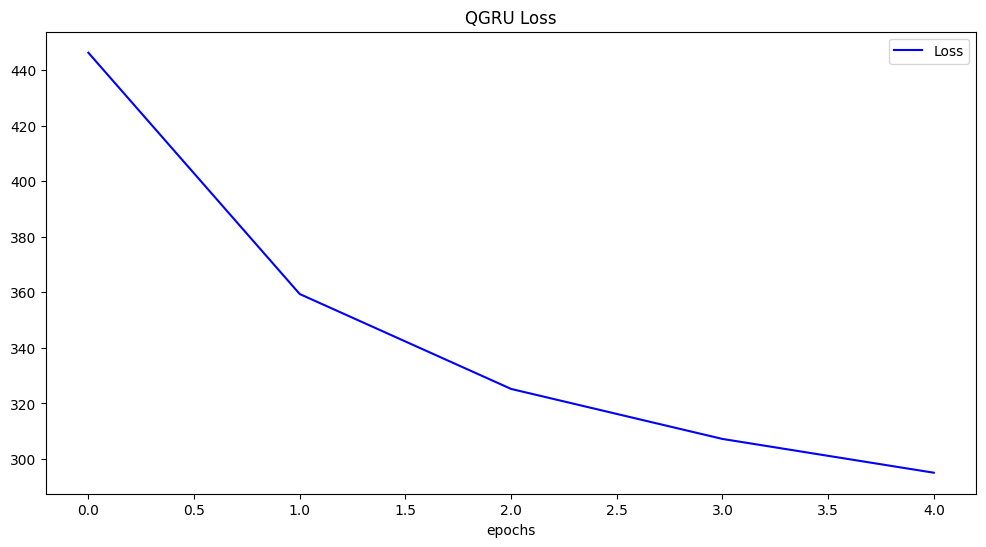

In [25]:
np.savetxt('./SavedModels/Electricity/steel_energy/loss/qgru.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QGRU Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [26]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)

print(pred_y_train)

tensor([-0.7315, -0.8676, -0.7787,  ..., -0.7093, -0.7211, -0.7187],
       grad_fn=<ViewBackward0>)


In [27]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)


In [28]:
pred_y_train

tensor([[-0.7315],
        [-0.8676],
        [-0.7787],
        ...,
        [-0.7093],
        [-0.7211],
        [-0.7187]], grad_fn=<ViewBackward0>)

In [29]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [30]:
np.savetxt('./SavedModels/Electricity/steel_energy/train/qgru.txt',y_train_pred)
np.savetxt('./SavedModels/Electricity/steel_energy/test/qgru.txt',y_test_pred)

Training dataset RMSE:19.142558598794437


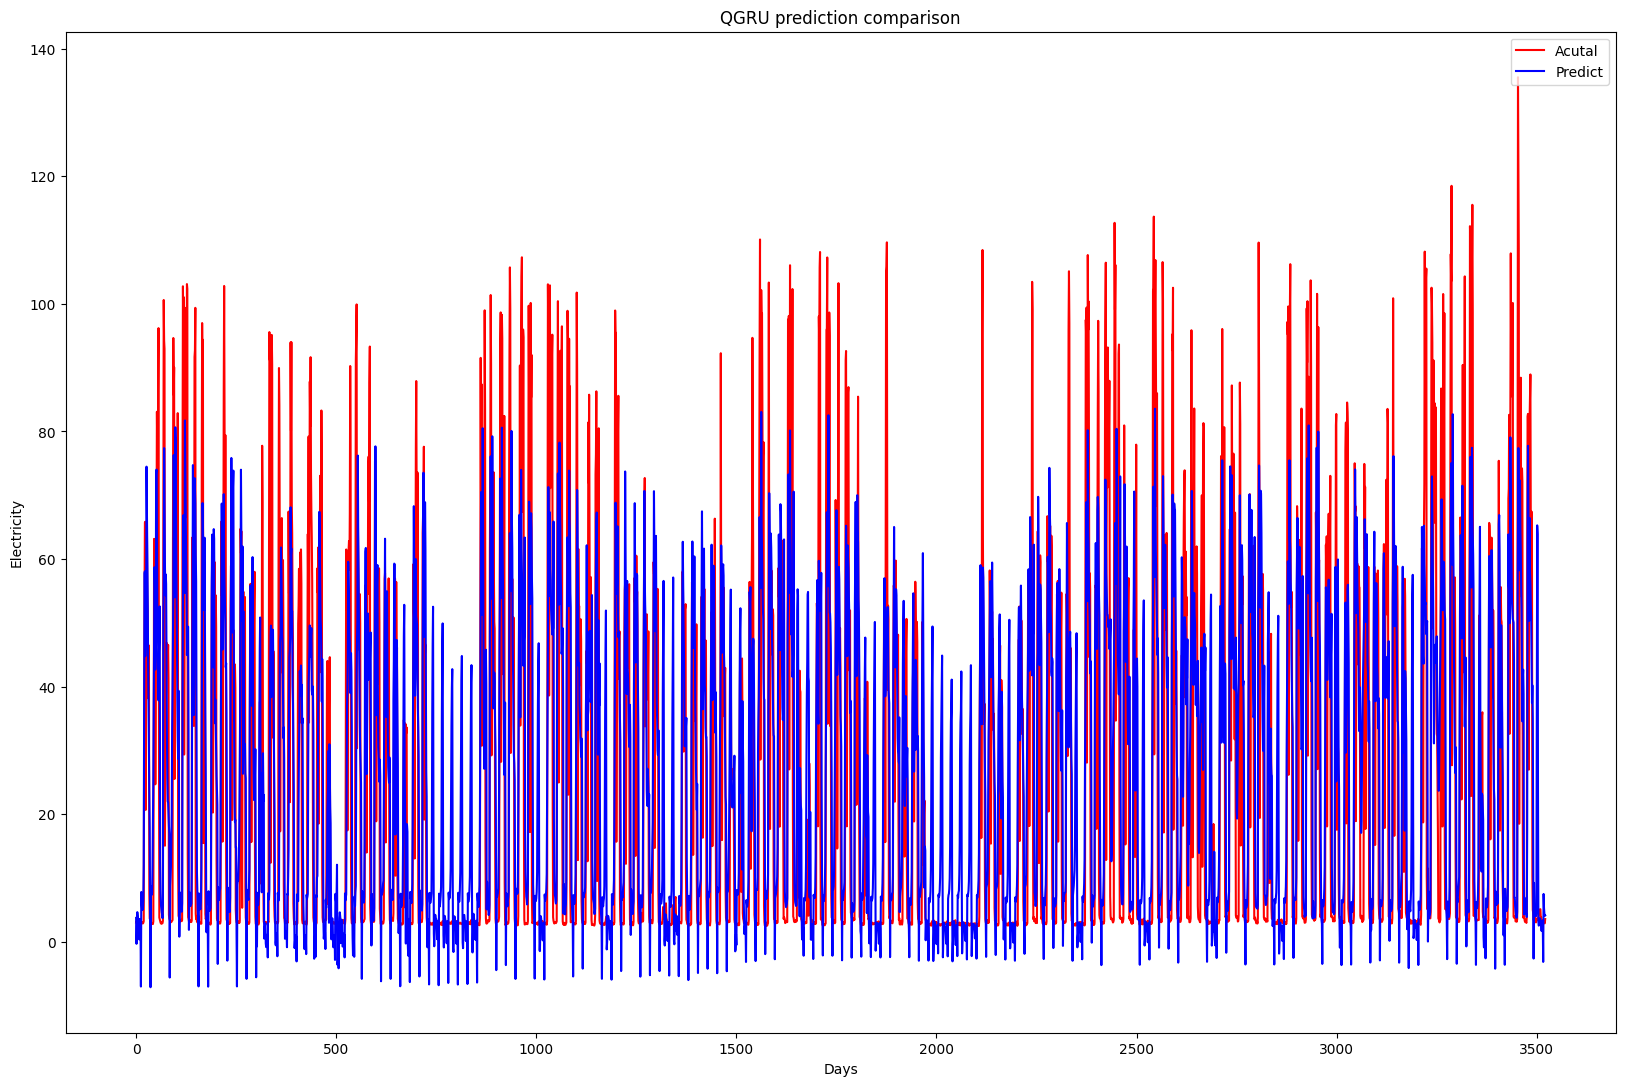

In [31]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QGRU prediction comparison')
plt.ylabel('Electricity')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:19.05582030306548


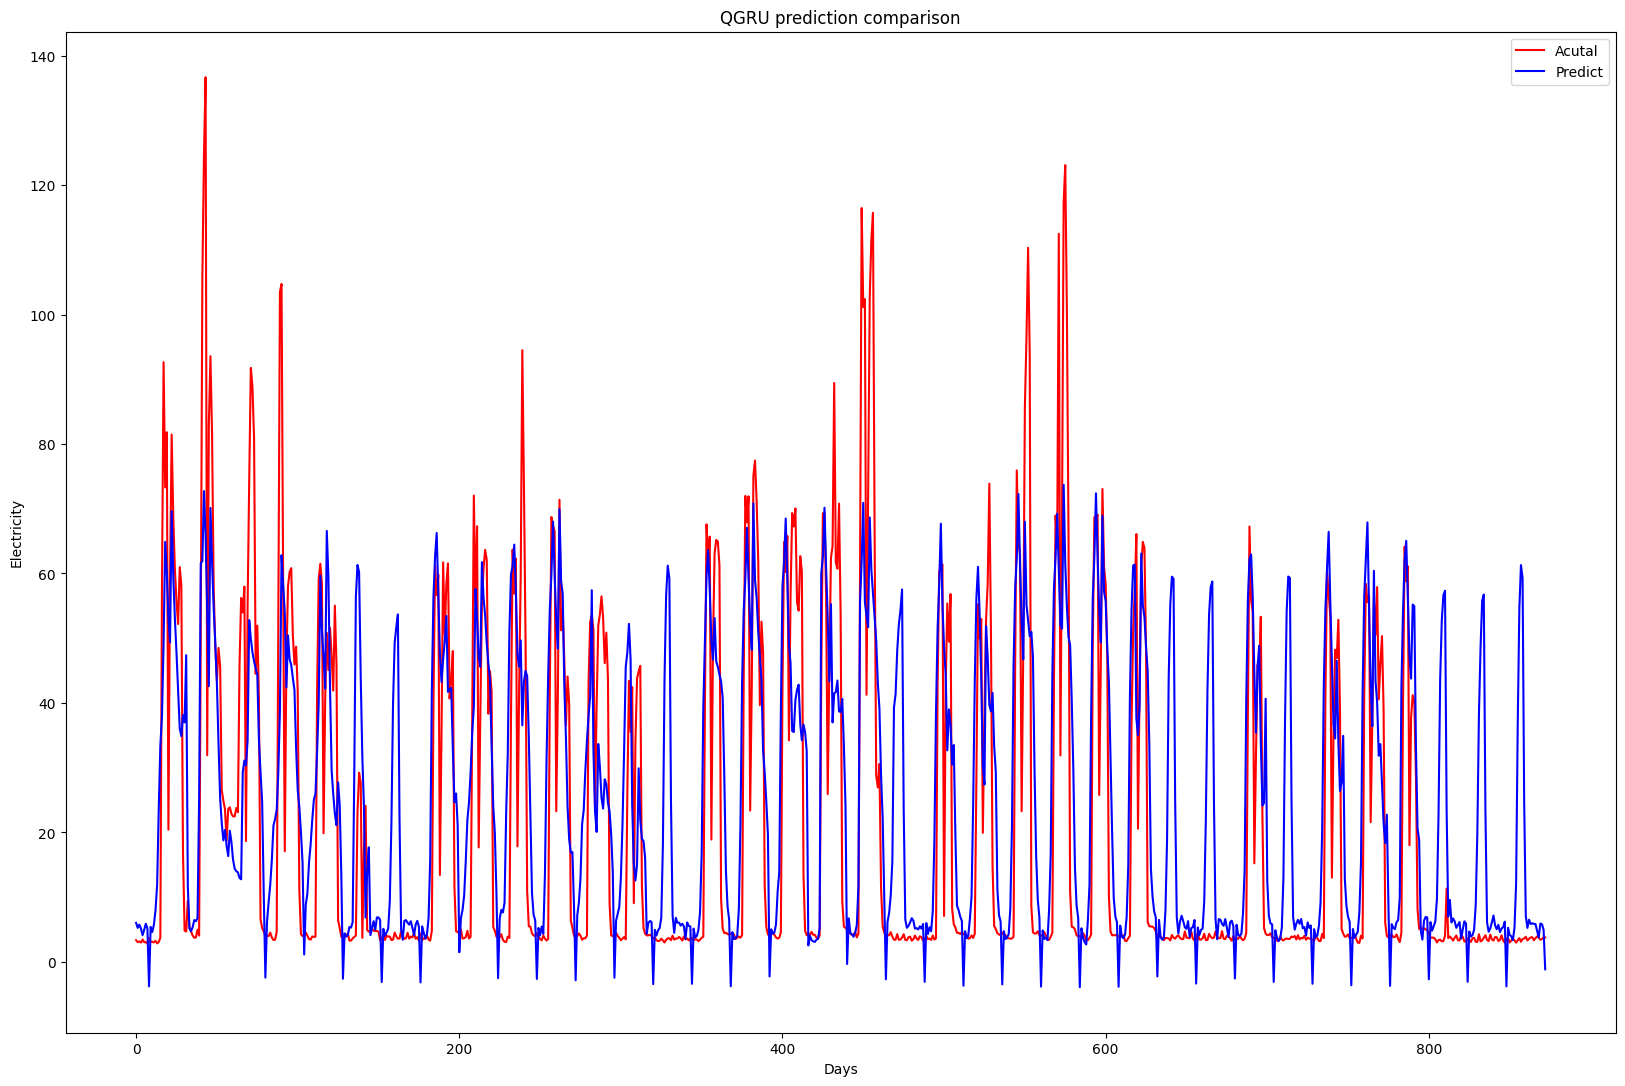

In [32]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QGRU prediction comparison')
plt.ylabel('Electricity')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [33]:
torch.save(modelQ.state_dict(),'./SavedModels/Electricity/steel_energy/model/QGRU_sd')